In [1]:
import re
import itertools
import numpy as np
import pandas as pd
from brainpy import isotopic_variants
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Set up plot aesthetics
titlefont = {'color':  'black',
        'weight': 'bold',
        'size': 20,
        } # Define how the plot titles should look

sns.set_context("talk") 
sns.set_style("ticks")

plt.rcParams.update({'font.size': 15})
                  #  'font.weight':'bold'}) #this is for the size of the adjusted plot labels
    
plt.rcParams['figure.dpi']= 300

In [3]:
## data_table below is formed using data contained within mendeleev library
data_table = pd.read_pickle("data_table")

In [4]:
# Take a look at some of the data - isotopes of carbon

data_table[data_table['symbol']=='C']

,atomic_number,symbol,mass,abundance,mass_number,mass_uncertainty,is_radioactive,half_life,half_life_unit,spin,g_factor,quadrupole_moment
10,6,C,12.000000,0.9884,12,0.000000e+00,False,NaN,None,0.0,0.000000,0.0
11,6,C,13.003355,0.0116,13,2.000000e-09,False,NaN,None,0.5,1.404824,0.0
12,6,C,NaN,NaN,14,NaN,True,NaN,None,3.0,0.273000,NaN


In [5]:
# relative double bond equivalent values for DBE calcs
dbe_vals = {'C':1,
            'H':-0.5,
            'O':0,
            'N':0.5,
            'S':0,
            'P':0.5,
            'Na':-0.5,
            'K':-0.5,
            'F':-0.5,
            'Cl':-0.5,
            'Br':-0.5,
            'I':-0.5,
            'Si':1}

In [6]:
class Formula():
    
    def __init__(self, input_formula, error_type='ppm', max_return=10, max_delta=500, nitrogen_rule='ignore', DBE_min=-1, DBE_max=10, decimal_places=4, charge_state=1):
        """Class for assigning formulae to masses

        Parameters
        ----------
        input_formula: passed to make_formulae function. String which represents numbers of each element. Should take the form:
        "Cx-y Hm-n" etc., for example "C20-22 H38-42 N0-6 O3-4 Na0-1"
        error_type: Either "mmu" (milli mass units), "ppm" (parts per million), or "amu" (atomic mass units)
        max_return: Number of formulae to return per m/z value in subsequent function calls
        max_delta: Largest acceptable mass error. No formulae with a mass error larger than this will be returned
        nitrogen_rule: Determines the kind of ions to consider, based on DBE values. Default is "ignore". "even e ions" considers even-electron ions, i.e. odd-DBE ions.
        "odd e ions" considers odd-electron ions, i.e. even-DBE ions (radical ions)
        decimal_places: Specifies the number of decimal places returned values are rounded to.
        charge_state: Charge state of ions to consider. Positive or negative non-zero integer.


        """        
        self.error_type = error_type
        self.max_return = max_return
        self.max_delta = max_delta
        self.formula = input_formula
        self.nitrogen_rule = nitrogen_rule
        self.DBE_min=DBE_min
        self.DBE_max=DBE_max
        self.decimal_places=decimal_places
        self.charge_state=charge_state
        self.formulae_combinations = self.make_formulae(input_string=self.formula, 
                                                        nitrogen_rule=self.nitrogen_rule,
                                                        DBE_min=self.DBE_min, 
                                                        DBE_max=self.DBE_max,
                                                        charge_state=self.charge_state)
            
        
        if self.error_type not in ['mmu','amu','ppm']:
            raise Exception(f"error_type provided is '{error_type}', should be either 'mmu', 'amu' or 'ppm'")
            
        if self.nitrogen_rule not in ['ignore','even e ions','odd e ions']:
            raise Exception(f"error_type provided is '{nitrogen_rule}', should be either 'ignore', 'even e ions' or 'odd e ions'")
            
        if self.charge_state == 0 or type(self.charge_state) == float: 
            raise Exception(f"charge_state provided is {charge_state} - {type(charge_state)}, should be a non-zero integer'")
            
        
    def make_formulae(self, input_string=str, nitrogen_rule='ignore',DBE_min=-1, DBE_max=10, charge_state=1):
        """Function to return df of all possible formulae and their masses, given a formula range. Adherance to the nitrogen rule can also be specified.

        Parameters
        ----------
        input_string: string which represents numbers of each element. Should take the form:
        "Cx-y Hm-n" etc., for example "C20-22 H38-42 N0-6 O3-4 Na0-1"

        """
        
        input_string=self.formula 
        nitrogen_rule=self.nitrogen_rule
        DBE_min=self.DBE_min
        DBE_max=self.DBE_max
        charge_state=self.charge_state

        list_of_substrings = []
        parsed_list_of_substrings = []

        for substring in re.findall(re.compile(r'([\S]*)'), input_string): #this regex captures groups separated by a "space" character
            list_of_substrings.append(substring)
        parsed_list_of_substrings = list(filter(None, list_of_substrings)) #filter out the None from regex - why does this occur?

        parsed_formula = {}
        list_of_elements = []

        for item in parsed_list_of_substrings:

            if "-" in item:
                for components in re.findall(re.compile(r'([A-Za-z]*)([\d]*)-([\d]*)'), item): #this regex splits substring into element and lower/upper bounds for range
                    parsed_formula[components[0]] = (components[1],components[2])
                    list_of_elements.append(components[0])

        # For elements parsed out of the above formula string, look up accurate monoisotopic masses and DBE values
        element_masses = {}
        element_dbe = {}

        for i in list_of_elements:
            subset = data_table[data_table['symbol']==i]
            element_masses[i] = float(subset.loc[[subset['abundance'].idxmax()]]['mass']) #this grabs the mass of the most abundant isotope
            element_dbe[i] = dbe_vals[i] #this grabs the corresponding DBE value for each element

        parsed_formula_ranges = {}
        for k,v in parsed_formula.items():
            parsed_formula_ranges[k] = (range(int(v[0]),int(v[1])+1)) #populate a dict with key=element and values=lower and upper bounds of element count

        list_of_combinations = []
        for v in itertools.product(*list(parsed_formula_ranges.values())):
            list_of_combinations.append(v) #add each possible combination of each element number to a list

        df_of_combinations = pd.DataFrame(list_of_combinations, columns=list_of_elements) #make a df of element combinations

        masses_of_combinations = pd.DataFrame(df_of_combinations*list(element_masses.values())).sum(axis=1).rename('Mass')
        dbes_of_combinations = (pd.DataFrame(df_of_combinations*list(element_dbe.values())).sum(axis=1).rename('DBE'))+1 #add 1 to DBE to account for +2H in DBE calc for saturation
        combos_with_appended_mass = pd.concat([df_of_combinations,masses_of_combinations,dbes_of_combinations], axis=1)

        #drop either side of DBE limits
        combos_with_appended_mass = combos_with_appended_mass[~((combos_with_appended_mass['DBE'] < DBE_min)|(combos_with_appended_mass['DBE'] > DBE_max))]
        combos_with_appended_mass = combos_with_appended_mass.sort_values('Mass')

        if nitrogen_rule== 'ignore':
            pass
        elif nitrogen_rule=='even e ions':
            combos_with_appended_mass = combos_with_appended_mass[combos_with_appended_mass['DBE'].apply(lambda x: x%1 ==0.5)] #select only rows where DBE isn't whole number
        elif nitrogen_rule=='odd e ions':
            combos_with_appended_mass = combos_with_appended_mass[combos_with_appended_mass['DBE'].apply(lambda x: x%1 ==0)] #select only rows where DBE is a whole number

        combos_with_appended_mass['Mass'] = combos_with_appended_mass['Mass']/abs(charge_state)
        combos_with_appended_mass.rename(columns={'Mass':'m/z'}, inplace=True)

        return combos_with_appended_mass
    
        
        
    def assign_from_mass(self, input_mass=float, pass_to_list_func=False):
        """Function to assign formulae to a given mass or m/z value, ranked by mass error

        Function takes in an accurate mass or m/z and calculates a given type of mass error against masses contained within a formulae table.
        Formulae are then ranked by ascending absolute mass error (Delta) and n lowest mass error candidate formulae are returned.

        Parameters
        ----------
        input_mass: Accurate measured mass 
        pass_to_list_func: Control behind-the-scenes behaviour based on whether output is used directly by mass_list_formulae_assigner function. 
        Default is False for calls of assign_from_mass function, and overwritten with True when called from within mass_list_formulae_assigner function.


        """
        formula_combinations=self.formulae_combinations
        error_type = self.error_type
        max_return = self.max_return
        max_delta = self.max_delta
        decimal_places = self.decimal_places
        
        #trim combinations df by: calculating absolute mass error, sorting the result, taking top n (lowest error) values
        formula_combinations = formula_combinations.iloc[(formula_combinations['m/z']-input_mass).abs().argsort()[:max_return]].reset_index(drop=True)

        if error_type=="mmu":
            formula_combinations['Delta'] = (input_mass - formula_combinations['m/z'])*1000
        if error_type=="amu":
            formula_combinations['Delta'] = (input_mass - formula_combinations['m/z'])
        if error_type=="ppm":
            formula_combinations['Delta'] = ((input_mass - formula_combinations['m/z']) / input_mass)*1000000

        formula_combinations = formula_combinations[formula_combinations['Delta'].abs() <= max_delta] #only take forwards results with error less than max_delta

        formula_strings = []
        col_names = formula_combinations.columns[:-1] #select column names except last - this corresponds to list of elements

        for i in range(len(formula_combinations)):
            row = formula_combinations.iloc[i,:-3]
            formula_tuple = (list(zip(col_names,row.astype(int))))
            formula_string = (' '.join(map(lambda x: str(x[0]) + '' + str(x[1]), formula_tuple)))
            formula_strings.append(formula_string) #nice print version of formula

        formula_strings = pd.Series(formula_strings, dtype='object').rename('Formula')#.reset_index(drop=True) #dtype specified as object here - is this ok?
        formula_combinations = pd.concat([formula_combinations,formula_strings],axis=1)
        dbe_col = formula_combinations['DBE']
        formula_combinations = formula_combinations.drop(['DBE'], axis=1)
        formula_combinations = pd.concat([formula_combinations,dbe_col],axis=1) #this and above 2 lines are used to reorder the df for nice print
        
        formula_combinations=formula_combinations.round(decimals={'m/z':decimal_places,
                                                                  'Delta':1}) #round the mass value to 'decimal_places' DP, and Delta to 1 DP (no need to assign as variable?)
        
        if pass_to_list_func==True: #this is to ensure the right column name is present if passed to the mass_list function
            pass
        elif error_type=="mmu":
            formula_combinations.rename(columns={'Delta':'Delta (mmu)'}, inplace=True)
        elif error_type=="amu":
            formula_combinations.rename(columns={'Delta':'Delta (amu)'}, inplace=True)
        elif error_type=="ppm":
            formula_combinations.rename(columns={'Delta':'Delta (ppm)'}, inplace=True)
            
        return formula_combinations
    
    
    def mass_list_formulae_assigner(self, xy_data, multiindex=False):
        """Function to assign formulae to a given list of masses, ranked by mass error

        Function provides an ease-of-use variant of assign_from_mass function for assigning formulae to each m/z value in a mass list.
        Each m/z value in the mass list provided is supplied to assign_from_mass function and results are assembled into a DataFrame.

        Parameters
        ----------
        xy_data: Mass list data to perform formulae assignment on. Accepted types for xy_data are list or pd.DataFrame. 
        For pd.DataFrame, it is assumed the first column contains m/z values.
        multiindex: Sets behaviour for the returned DataFrame. Default behaviour is False, which returns unique rows for each m/z-formula pair. Setting to true will return
        the resultant DataFrame with a multiindex of m/z and formula.


        """    
        formula_combinations=self.formulae_combinations
        error_type = self.error_type
        max_return = self.max_return
        max_delta = self.max_delta
        decimal_places = self.decimal_places
        
        df = pd.DataFrame()

        ##Add in some peak-picking functionality?
        if isinstance(xy_data,pd.DataFrame):
            for i in range(len(xy_data)):
                mz = xy_data.iloc[i,0]
                mz_assignment = self.assign_from_mass(input_mass=mz,pass_to_list_func=True)
                mz_assignment['Exp. m/z'] = mz
                df = df.append(mz_assignment)

            return_data = df.copy()
            return_data = return_data[['Exp. m/z','Formula','m/z','Delta','DBE']].copy()
            return_data.rename(columns={'m/z':'Theo. m/z'}, inplace=True)
            return_data=return_data.round(decimals={'Exp. m/z':decimal_places,
                                            'Theo. m/z':decimal_places})
            if multiindex == False:
                return_data = return_data.reset_index(drop=True)
            elif multiindex == True:
                return_data = return_data.set_index(['Exp. m/z', 'Formula'])

        if isinstance(xy_data,list):
            for i in range(len(xy_data)):
                mz = xy_data[i]
                mz_assignment = self.assign_from_mass(input_mass=mz,pass_to_list_func=True)
                mz_assignment['Exp. m/z'] = mz
                df = df.append(mz_assignment)

            return_data = df.copy()
            return_data = return_data[['Exp. m/z','Formula','m/z','Delta','DBE']].copy()
            return_data.rename(columns={'m/z':'Theo. m/z'}, inplace=True)
            return_data=return_data.round(decimals={'Exp. m/z':decimal_places,
                                            'Theo. m/z':decimal_places})

            if multiindex == False:
                return_data = return_data.reset_index(drop=True)
            elif multiindex == True:
                return_data = return_data.set_index(['Exp. m/z', 'Formula'])
            
        if type(xy_data) not in [pd.DataFrame,list]:
            raise Exception(f"data type of data provided is '{type(xy_data)}', should be either pd.DataFrame or list'")
            
        if error_type=="mmu":
            return_data.rename(columns={'Delta':'Delta (mmu)'}, inplace=True)
        elif error_type=="amu":
            return_data.rename(columns={'Delta':'Delta (amu)'}, inplace=True)
        elif error_type=="ppm":
            return_data.rename(columns={'Delta':'Delta (ppm)'}, inplace=True)


        return(return_data)

In [7]:
formula_assigner = Formula("C0-40 H0-80 N0-6 O1-10 Na0-1", error_type='ppm', max_delta=5, nitrogen_rule='even e ions', DBE_max=20, charge_state=1)
formula_assigner.formulae_combinations

,C,H,N,O,Na,m/z,DBE
140,0,1,0,1,0,17.002740,0.5
420,0,3,0,1,0,19.018390,-0.5
11480,1,1,0,1,0,29.002740,1.5
20,0,0,1,1,0,29.997989,1.5
11760,1,3,0,1,0,31.018390,0.5
...,...,...,...,...,...,...,...
463819,40,72,6,10,1,819.520762,7.5
464099,40,74,6,10,1,821.536412,6.5
464379,40,76,6,10,1,823.552062,5.5
464659,40,78,6,10,1,825.567712,4.5


In [8]:
# let's see if we can get a match from the reserpine [M+H]+ ion (C33 H41 N2 O9) with a monoisotopic mass from chemdraw of 609.2807
formula_assigner.assign_from_mass(609.2807)

,C,H,N,O,Na,m/z,Delta (ppm),Formula,DBE
0,33,41,2,9,0,609.2812,-0.8,C33 H41 N2 O9 Na0,14.5
1,32,38,6,5,1,609.2801,0.9,C32 H38 N6 O5 Na1,16.5
2,34,37,6,5,0,609.2825,-3.0,C34 H37 N6 O5 Na0,19.5
3,31,42,2,9,1,609.2788,3.1,C31 H42 N2 O9 Na1,11.5
4,36,42,0,7,1,609.2828,-3.5,C36 H42 N0 O7 Na1,15.5


In [9]:
# What about reserpine [M+Na]+ ion (C33 H40 N2 O9 Na0) with a monoisotopic mass from chemdraw of 631.2626
formula_assigner.assign_from_mass(631.2626)

,C,H,N,O,Na,m/z,Delta (ppm),Formula,DBE
0,33,40,2,9,1,631.2632,-0.9,C33 H40 N2 O9 Na1,14.5
1,34,36,6,5,1,631.2645,-3.0,C34 H36 N6 O5 Na1,19.5
2,35,39,2,9,0,631.2656,-4.7,C35 H39 N2 O9 Na0,17.5


In [10]:
# Deprotonated reserpine ([M-H]- ion, C33 H39 N2 O9)? Reinstantiate the Formula class with charge set to -1
Formula("C0-40 H0-80 N0-6 O1-10 Na0-1", error_type='ppm', max_delta=5, nitrogen_rule='even e ions', DBE_max=20, charge_state=-1).assign_from_mass(607.2661)

,C,H,N,O,Na,m/z,Delta (ppm),Formula,DBE
0,33,39,2,9,0,607.2656,0.9,C33 H39 N2 O9 Na0,15.5
1,36,40,0,7,1,607.2672,-1.8,C36 H40 N0 O7 Na1,16.5
2,32,36,6,5,1,607.2645,2.7,C32 H36 N6 O5 Na1,17.5
3,31,40,2,9,1,607.2632,4.9,C31 H40 N2 O9 Na1,12.5


In [11]:
def isotope_simulation(assignment_df, output_shape, sigma=0.0002, n_peaks=5, include_list=True):
    
    if isinstance(assignment_df,pd.core.frame.DataFrame):
        element_dict = {} #declare a blank dict to store element and number of element data in
        for element in range(assignment_df.columns.get_loc('m/z')): #for each col up to m/z in df passed to function, use col name as key and row value as number of atoms value
            element_dict[assignment_df.columns[element]] = assignment_df.iloc[0,element]
        formula = "" #string representation for all key,val pairs in dict
        for key in element_dict:
            formula += (f"{key}{element_dict[key]} ")
            
    elif isinstance(assignment_df, dict):
        element_dict = assignment_df
        formula = "" #string representation for all key,val pairs in dict
        for key in assignment_df:
            formula += (f"{key}{assignment_df[key]} ")
            
    else:
        raise Exception("""assignment_df passed to isotope_simulation function should either be output of 
                        assign_from_mass function or a dict of the type {'H': 42, 'C': 25, 'O': 3, 'Na': 1}""")
        
    theoretical_isotopic_cluster = isotopic_variants(element_dict, npeaks=n_peaks, charge=0)
    
    if output_shape == 'centroid':
        cluster_df = pd.DataFrame(columns=['m/z','Intensity'])
        for row in range(len(theoretical_isotopic_cluster)):
            cluster_df = cluster_df.append(pd.Series(data={'m/z':theoretical_isotopic_cluster[row].mz,
                                                           'Intensity': theoretical_isotopic_cluster[row].intensity}), ignore_index=True)
    elif output_shape == 'gaussian':
        mz_grid = np.arange(theoretical_isotopic_cluster[0].mz - 1,
                    theoretical_isotopic_cluster[-1].mz + 1, 0.02)
        intensity = np.zeros_like(mz_grid)
        sigma = sigma
        
        for peak in theoretical_isotopic_cluster:             # Add gaussian peak shape centered around each theoretical peak
            intensity += peak.intensity * np.exp(-(mz_grid - peak.mz) ** 2 / (2 * sigma)
                    ) / (np.sqrt(2 * np.pi) * sigma)

        cluster_df = pd.DataFrame(data={'m/z':mz_grid,'Intensity':intensity})
    
    else:
        raise Exception("output_shape should be either 'centroid' or 'gaussian'")
        
    cluster_df['Intensity'] = (cluster_df['Intensity'] / cluster_df['Intensity'].max()) * 100    # Normalize profile to 0-100

    fig, ax1 = plt.subplots(figsize=(10,6), constrained_layout=True, sharex=True)     # draw the profile

    if output_shape == 'centroid':
        markerline, stemlines, baseline = ax1.stem(cluster_df['m/z'],cluster_df['Intensity'], markerfmt='', basefmt='tab:blue', #linefmt={linewidth:5},
                       use_line_collection=True)
        plt.setp(stemlines, 'linewidth', 2)
        plt.setp(markerline, 'linestyle', '')
    if output_shape == 'gaussian':
        sns.lineplot(cluster_df['m/z'],cluster_df['Intensity'], ax=ax1)

    plt.sca(ax1)
    ax1.set_yticks(range(0,109,20))
    ax1.set_yticks(range(0,104,5), minor=True)
    plt.ylim(bottom=-0.5, top=109.99)
    plt.title(f'Isotope Distribution for {formula}', fontdict=titlefont, pad=10)
    plt.ylabel('Relative Intensity (%)', labelpad=-5)
    plt.xlabel('m/z')
    
    # Add in peak labels - recalculate cluster_df data to avoid separate treatment of gaussian and centroid workflows
    masslist = pd.DataFrame(columns=['m/z','Intensity'])
    for row in range(len(theoretical_isotopic_cluster)):
        masslist = masslist.append(pd.Series(data={'m/z':theoretical_isotopic_cluster[row].mz,
                     'Intensity': theoretical_isotopic_cluster[row].intensity}), ignore_index=True)
    masslist['Intensity'] = (masslist['Intensity'] / masslist['Intensity'].max()) * 100    # Normalize profile to 0-100
        
    for i in range(len(masslist)):
            intensity = masslist.iloc[i]['Intensity']
            mz = masslist.iloc[i]['m/z']
            if masslist.iloc[i]['Intensity'] >=3:
                ax1.annotate(mz.round(4), xy=(mz, intensity), xycoords='data',
                                xytext=(mz+0.1, intensity+3), textcoords='data',
                                arrowprops=dict(arrowstyle="-",
                                                color="grey"))
            if include_list == True:
                plt.text(0.99, 0.95-i*(0.05), f'{mz:.4f} m/z - {intensity:.1f} %', horizontalalignment='right',
                 verticalalignment='center', transform=ax1.transAxes, fontdict=dict(color='grey'))
            if include_list == False:
                continue 

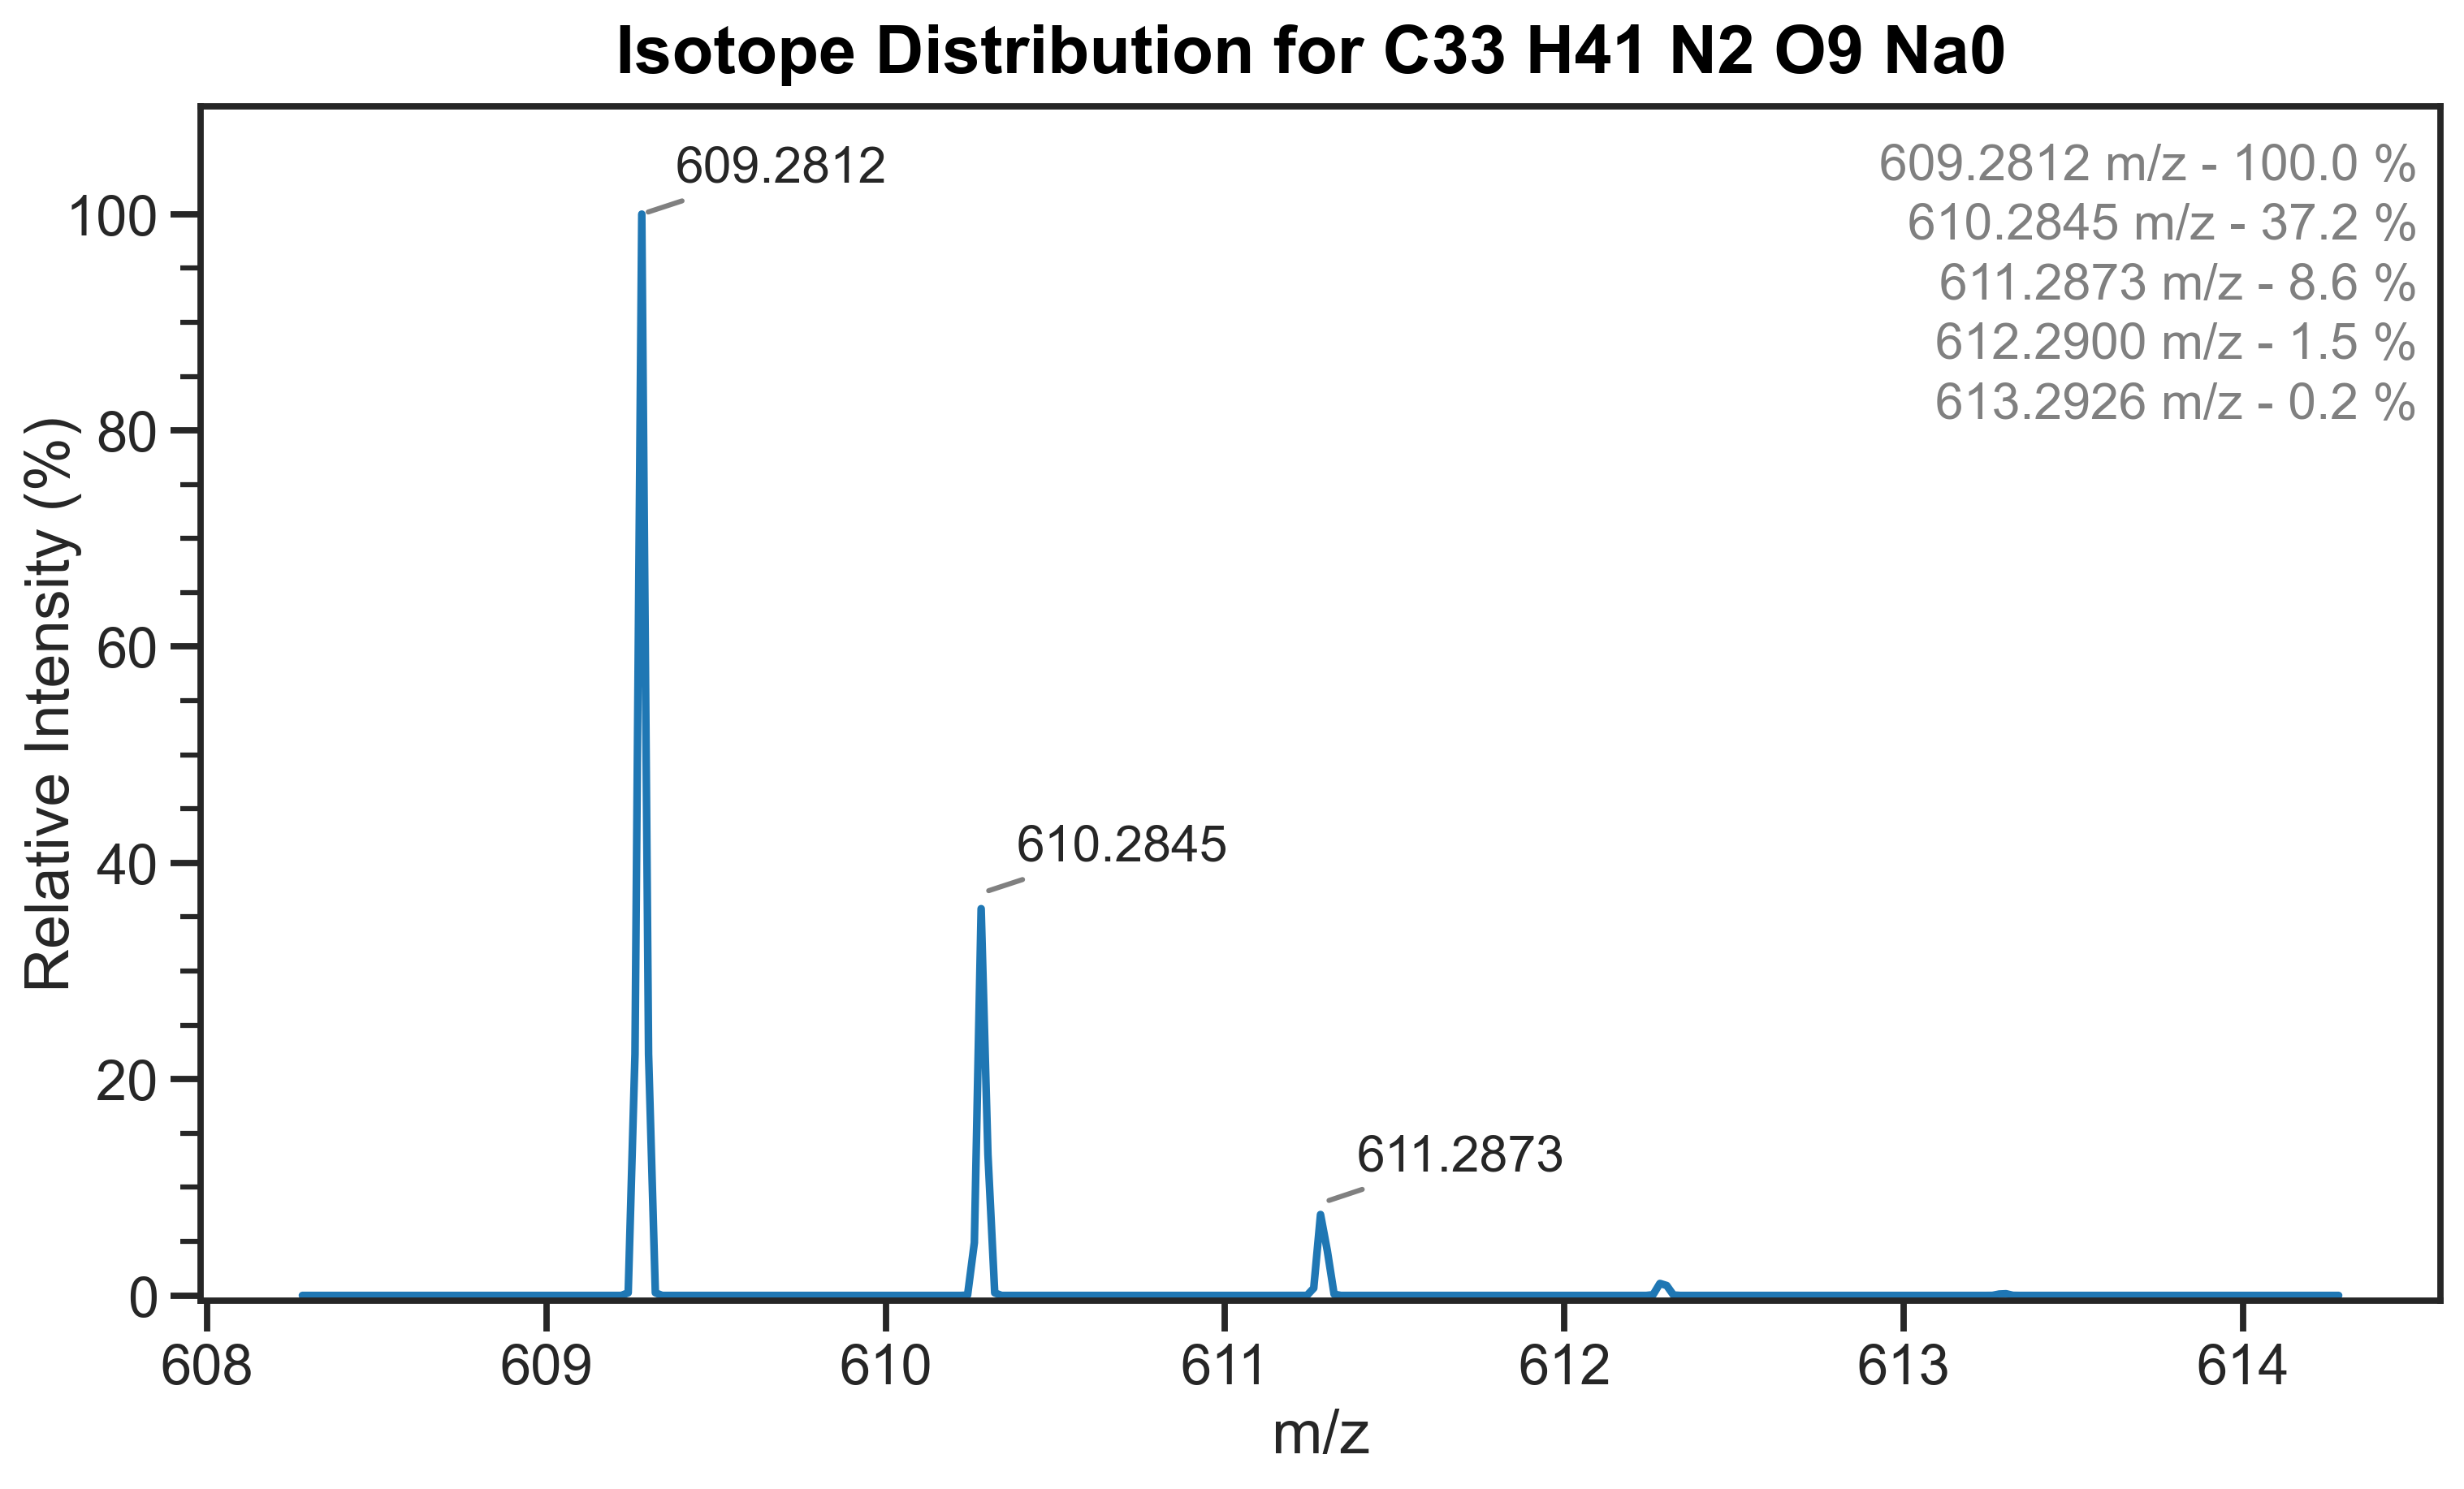

In [12]:
# We can call an simulated spectrum directly on the assign_from_mass function
# This will assume the top match from the assign_from_mass function is the formula you wish to plot
isotope_simulation(formula_assigner.assign_from_mass(input_mass=609.2807),'gaussian', sigma=(1/7500))

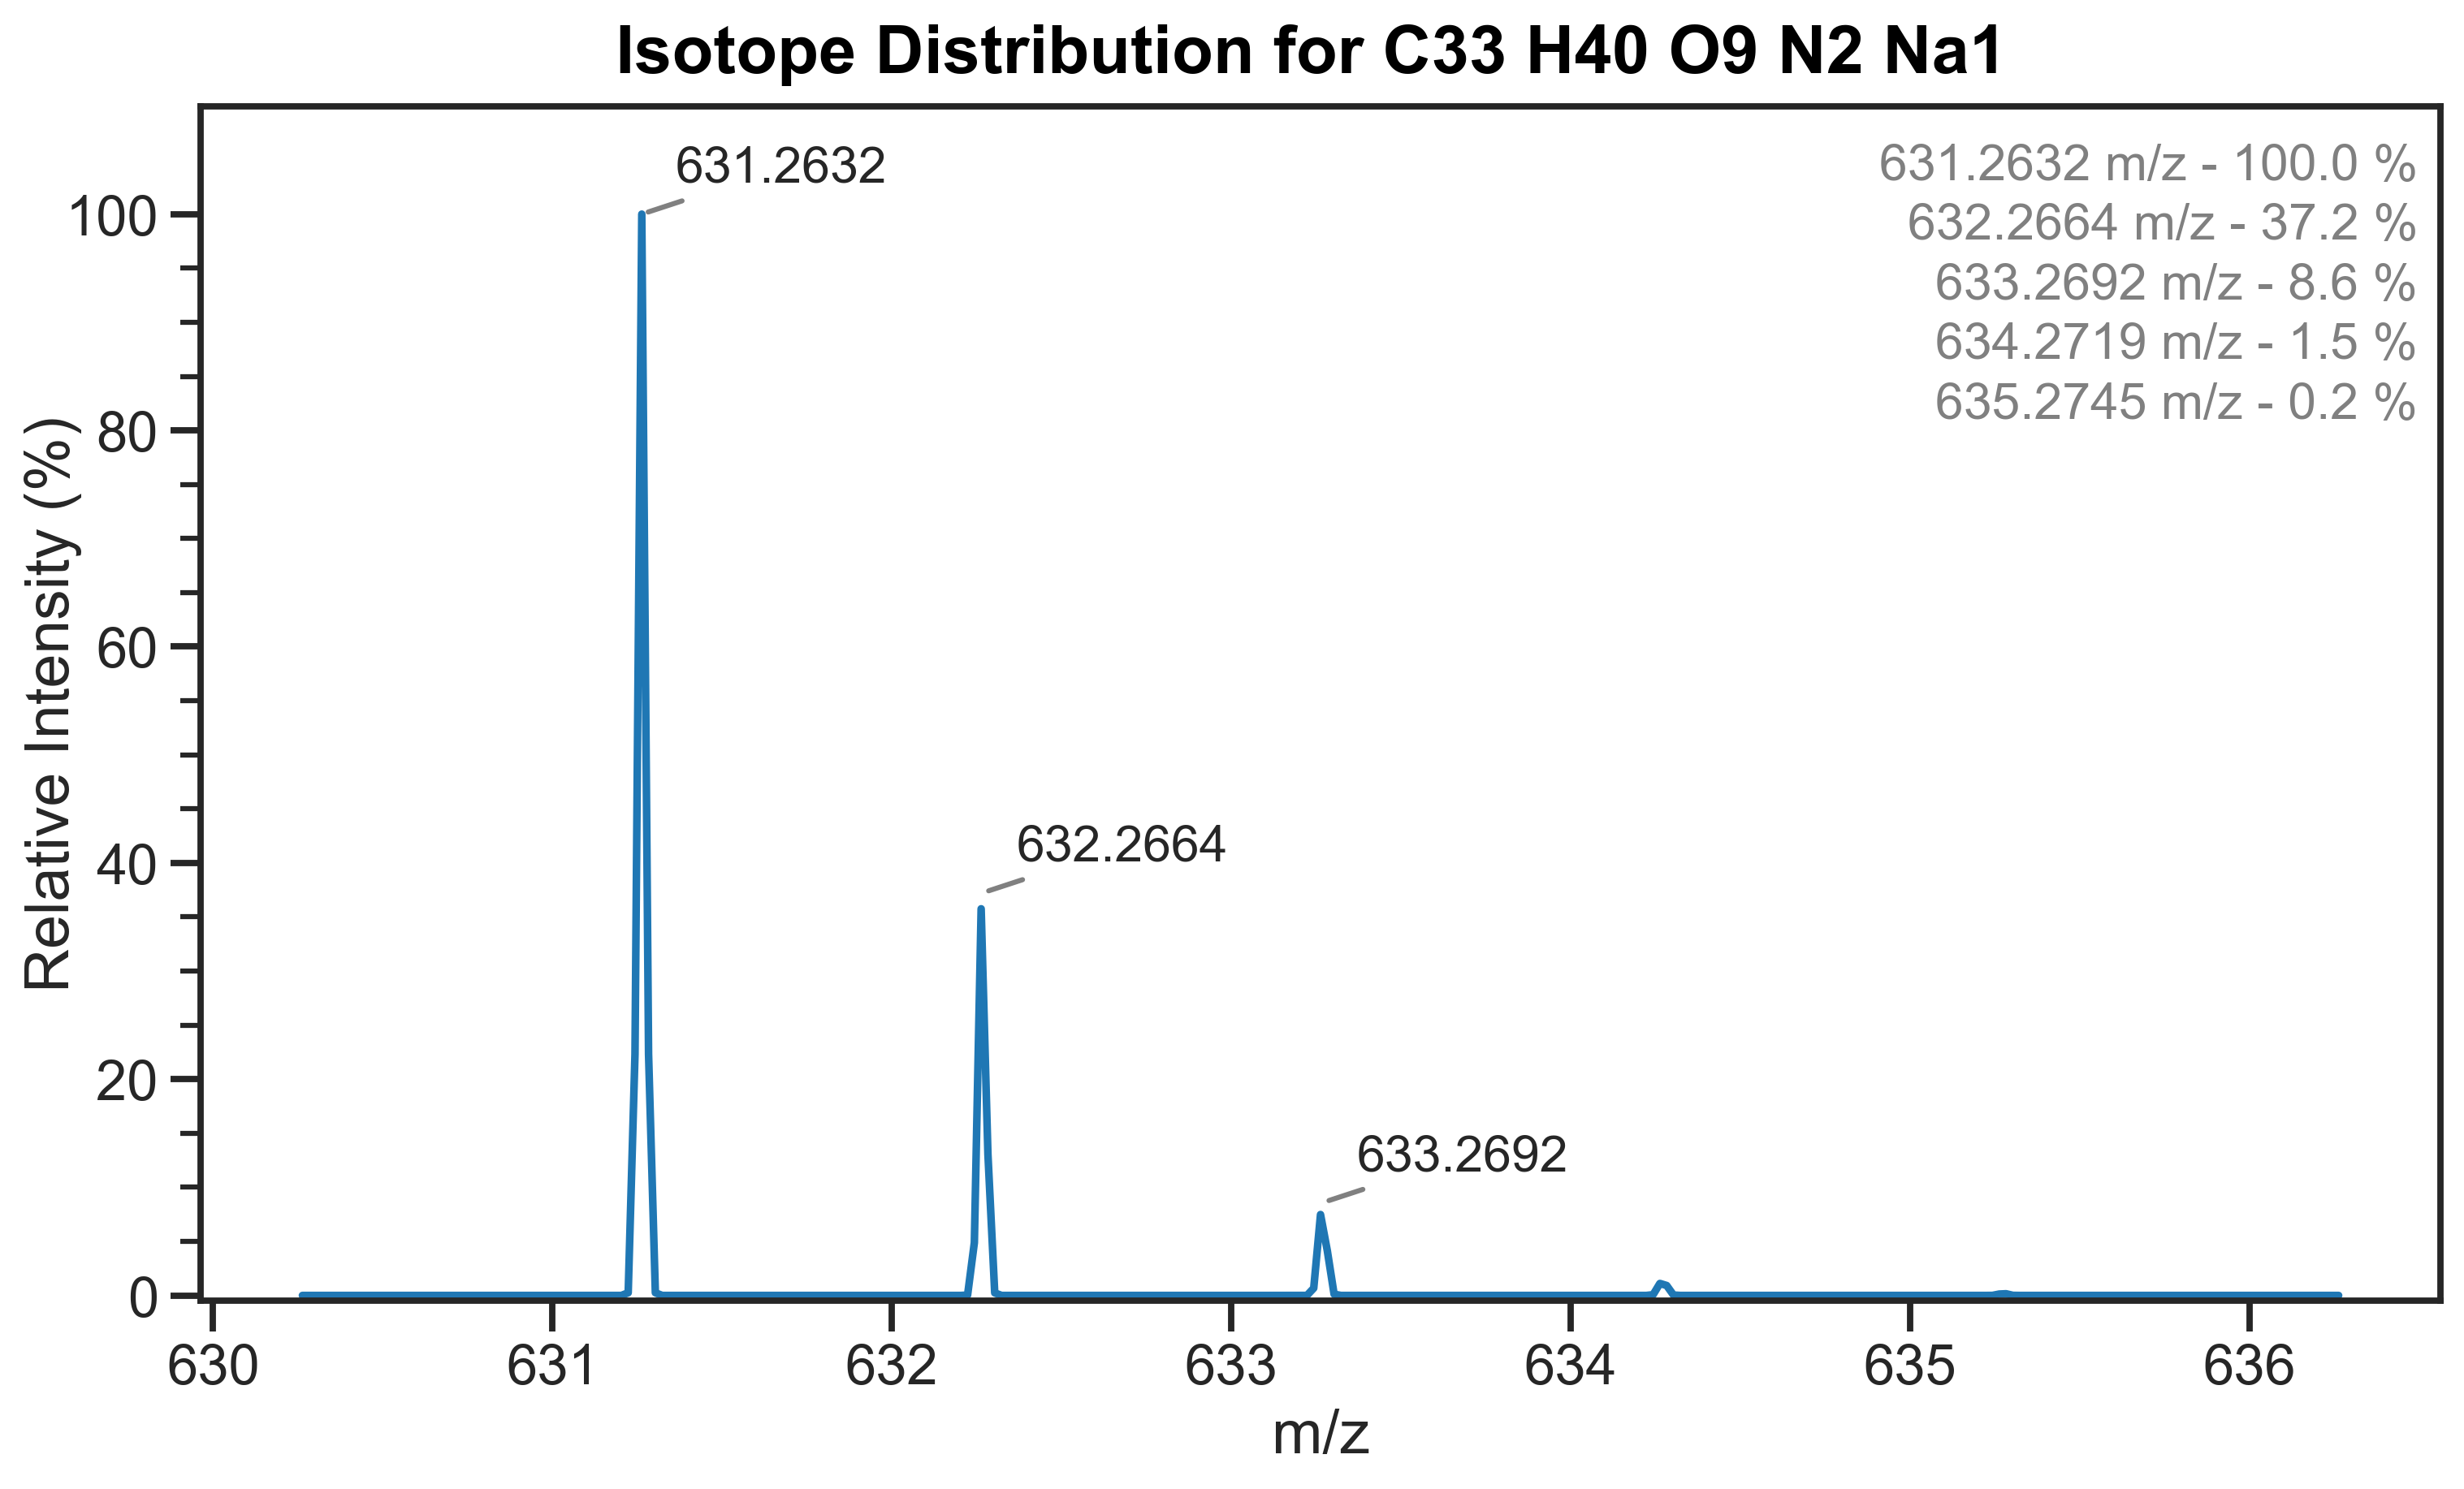

In [13]:
# We can also call a simulated spectrum from a dictionary of element-number pairs - below is reserpine [M+Na]+ ion
isotope_simulation({'C': 33, 'H': 40, 'O': 9, 'N':2, 'Na': 1},'gaussian', sigma=(1/7500))

In [14]:
# Run the mass_list_formulae_assigner function on a dataframe of common MS-ions
trial_df = pd.DataFrame([(413.26623, 100), # diisooctyl phthalate, [M+Na]+, C24 H38 O4 Na1
                         (609.2807, 24.0), # reserpine, [M+H]+, C33 H41 N2 O9 
                         (631.2626, 80.5)], #reserpine, [M+Na]+, C33 H40 N2 O9 Na1	
                          columns=('m/z','Intensity'))

formula_assigner.mass_list_formulae_assigner(trial_df)

,Exp. m/z,Formula,Theo. m/z,Delta (ppm),DBE
0,413.2662,C22 H33 N6 O2 Na0,413.2665,-0.7,9.5
1,413.2662,C24 H38 N0 O4 Na1,413.2668,-1.3,5.5
2,413.2662,C21 H37 N2 O6 Na0,413.2652,2.6,4.5
3,609.2807,C33 H41 N2 O9 Na0,609.2812,-0.8,14.5
4,609.2807,C32 H38 N6 O5 Na1,609.2801,0.9,16.5
5,609.2807,C34 H37 N6 O5 Na0,609.2825,-3.0,19.5
6,609.2807,C31 H42 N2 O9 Na1,609.2788,3.1,11.5
7,609.2807,C36 H42 N0 O7 Na1,609.2828,-3.5,15.5
8,631.2626,C33 H40 N2 O9 Na1,631.2632,-0.9,14.5
9,631.2626,C34 H36 N6 O5 Na1,631.2645,-3.0,19.5


In [15]:
# Run the mass_list_formulae_assigner function on a dataframe of common MS-ions, this time with multiindex set to True
trial_df = pd.DataFrame([(413.26623, 100), # diisooctyl phthalate, [M+Na]+, C24 H38 O4 Na1
                         (609.2807, 24.0), # reserpine, [M+H]+, C33 H41 N2 O9 
                         (631.2626, 80.5)], #reserpine, [M+Na]+, C33 H40 N2 O9 Na1	
                          columns=('m/z','Intensity'))

formula_assigner.mass_list_formulae_assigner(trial_df, multiindex=True)

Theo. m/z  Delta (ppm)   DBE
Exp. m/z Formula                                        
413.2662 C22 H33 N6 O2 Na0   413.2665         -0.7   9.5
         C24 H38 N0 O4 Na1   413.2668         -1.3   5.5
         C21 H37 N2 O6 Na0   413.2652          2.6   4.5
609.2807 C33 H41 N2 O9 Na0   609.2812         -0.8  14.5
         C32 H38 N6 O5 Na1   609.2801          0.9  16.5
         C34 H37 N6 O5 Na0   609.2825         -3.0  19.5
         C31 H42 N2 O9 Na1   609.2788          3.1  11.5
         C36 H42 N0 O7 Na1   609.2828         -3.5  15.5
631.2626 C33 H40 N2 O9 Na1   631.2632         -0.9  14.5
         C34 H36 N6 O5 Na1   631.2645         -3.0  19.5
         C35 H39 N2 O9 Na0   631.2656         -4.7  17.5

In [16]:
# We can also run the mass_list_formulae_assigner function on a list of common MS-ions
trial_df = [413.26623, # diisooctyl phthalate, [M+Na]+, C24 H38 O4 Na1
            609.2807, # reserpine, [M+H]+, C33 H41 N2 O9 
            631.2626] #reserpine, [M+Na]+, C33 H40 N2 O9 Na1	
                          

formula_assigner.mass_list_formulae_assigner(trial_df)

,Exp. m/z,Formula,Theo. m/z,Delta (ppm),DBE
0,413.2662,C22 H33 N6 O2 Na0,413.2665,-0.7,9.5
1,413.2662,C24 H38 N0 O4 Na1,413.2668,-1.3,5.5
2,413.2662,C21 H37 N2 O6 Na0,413.2652,2.6,4.5
3,609.2807,C33 H41 N2 O9 Na0,609.2812,-0.8,14.5
4,609.2807,C32 H38 N6 O5 Na1,609.2801,0.9,16.5
5,609.2807,C34 H37 N6 O5 Na0,609.2825,-3.0,19.5
6,609.2807,C31 H42 N2 O9 Na1,609.2788,3.1,11.5
7,609.2807,C36 H42 N0 O7 Na1,609.2828,-3.5,15.5
8,631.2626,C33 H40 N2 O9 Na1,631.2632,-0.9,14.5
9,631.2626,C34 H36 N6 O5 Na1,631.2645,-3.0,19.5
